In [1]:
import os
import sklearn
import sklearn.datasets
import sklearn.ensemble
import xgboost
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

from omnixai.data.tabular import Tabular
import sys  
sys.path.insert(0, '../src/')
import matplotlib.pyplot as plt

import featureExtraction as fe

import evaluate as ev


WINDOW_SIZE = 256
OVERLAP_FACTOR = 0.5

fe_dataset = fe.FeatureExtractor('ours', WINDOW_SIZE, OVERLAP_FACTOR)
fe_dataset.extract_features()
fe_dataset.standarization()

In [3]:
def column_names():
    names = []
    for sensor in ["acc","mag","gyro"]:
        for axis in ["x","y","z"]:
            for feature in ["mean","median","stds","vars","mins","max","mean-crossings","mean-mags","energy","entropy","zero-crossing"]:
                names.append(sensor+"_"+axis+"_"+feature)
    return names

feature_names = column_names()
df = pd.DataFrame(fe_dataset.features,columns = feature_names)
df.insert(len(feature_names), "label", fe_dataset.labels, True)
#df = df.drop(["mag_y_stds"],axis=1)
pd.set_option('display.max_columns', None)
df

,acc_x_mean,acc_x_median,acc_x_stds,acc_x_vars,acc_x_mins,acc_x_max,acc_x_mean-crossings,acc_x_mean-mags,acc_x_energy,acc_x_entropy,acc_x_zero-crossing,acc_y_mean,acc_y_median,acc_y_stds,acc_y_vars,acc_y_mins,acc_y_max,acc_y_mean-crossings,acc_y_mean-mags,acc_y_energy,acc_y_entropy,acc_y_zero-crossing,acc_z_mean,acc_z_median,acc_z_stds,acc_z_vars,acc_z_mins,acc_z_max,acc_z_mean-crossings,acc_z_mean-mags,acc_z_energy,acc_z_entropy,acc_z_zero-crossing,mag_x_mean,mag_x_median,mag_x_stds,mag_x_vars,mag_x_mins,mag_x_max,mag_x_mean-crossings,mag_x_mean-mags,mag_x_energy,mag_x_entropy,mag_x_zero-crossing,mag_y_mean,mag_y_median,mag_y_stds,mag_y_vars,mag_y_mins,mag_y_max,mag_y_mean-crossings,mag_y_mean-mags,mag_y_energy,mag_y_entropy,mag_y_zero-crossing,mag_z_mean,mag_z_median,mag_z_stds,mag_z_vars,mag_z_mins,mag_z_max,mag_z_mean-crossings,mag_z_mean-mags,mag_z_energy,mag_z_entropy,mag_z_zero-crossing,gyro_x_mean,gyro_x_median,gyro_x_stds,gyro_x_vars,gyro_x_mins,gyro_x_max,gyro_x_mean-crossings,gyro_x_mean-mags,gyro_x_energy,gyro_x_entropy,gyro_x_zero-crossing,gyro_y_mean,gyro_y_median,gyro_y_stds,gyro_y_vars,gyro_y_mins,gyro_y_max,gyro_y_mean-crossings,gyro_y_mean-mags,gyro_y_energy,gyro_y_entropy,gyro_y_zero-crossing,gyro_z_mean,gyro_z_median,gyro_z_stds,gyro_z_vars,gyro_z_mins,gyro_z_max,gyro_z_mean-crossings,gyro_z_mean-mags,gyro_z_energy,gyro_z_entropy,gyro_z_zero-crossing,label
0,-0.229089,-0.210813,-0.142095,-0.169778,0.161479,-0.067072,0.099355,-0.016687,-0.160851,0.139399,0.715358,0.035420,-0.006893,-0.113804,-0.180245,0.149726,-0.109364,-0.119610,0.042364,-0.193747,0.121470,1.229801,-0.213581,-0.199532,-0.157737,-0.220642,0.173928,0.002391,0.434929,-0.028845,-0.254000,0.173406,0.810872,-0.447037,-0.424851,-0.098214,-0.029978,-0.469169,-0.472195,-0.519765,-0.072627,-0.072802,0.155679,-0.195707,-0.955257,-0.951171,-0.419924,-0.038924,-0.841586,-1.024883,-0.112117,0.233766,0.034075,-0.288856,-0.188283,0.255607,0.256807,-0.255260,-0.015643,0.283165,0.218456,0.155994,-0.172059,-0.066023,0.155281,-0.215915,0.131219,0.057304,-0.418052,-0.253547,0.410370,-0.412545,0.058526,-0.382266,-0.254600,0.381405,1.118832,0.414972,0.333071,-0.344903,-0.250355,0.309315,-0.283266,0.183534,-0.257379,-0.250797,0.326701,0.624669,0.417784,0.281940,-0.340308,-0.219404,0.328538,-0.147062,0.025723,-0.256594,-0.222604,0.329783,0.351060,Car
1,-0.449031,-0.468804,-0.014357,-0.154181,-0.027015,-0.067072,-0.348801,0.048828,-0.144488,0.071237,-0.393571,-0.342446,-0.424078,-0.107713,-0.179508,0.084463,-0.106051,0.057560,0.062727,-0.189200,0.102919,0.367019,0.185760,0.300040,-0.157858,-0.220663,0.173928,0.002391,0.260832,0.001308,-0.245442,0.142167,0.339689,-0.589387,-0.578408,0.377611,-0.012052,-0.742838,-0.509967,-1.381580,0.433694,-0.054954,-0.188078,-0.195707,-0.954829,-0.951231,-0.397158,-0.038730,-0.852664,-1.001187,0.011063,0.263072,0.033911,-0.300555,-0.188283,0.260587,0.261143,-0.242281,-0.015576,0.286101,0.229923,-0.191292,-0.160887,-0.065868,0.149315,-0.215915,0.145086,0.039324,-0.395602,-0.252738,0.410370,-0.404816,0.085953,-0.361083,-0.253789,0.373920,0.344496,1.355375,0.982920,-0.202130,-0.237638,0.309315,-0.148039,0.289409,-0.154801,-0.224478,0.247708,-0.122232,0.964658,0.810218,-0.244198,-0.212682,0.328538,-0.147062,0.325828,-0.176214,-0.207883,0.272687,-0.055147,Car
2,-0.453679,-0.455101,-0.003846,-0.152677,-0.027015,-0.175697,0.016201,-0.056141,-0.143184,0.132513,-0.880417,-0.155425,-0.225465,-0.105394,-0.179224,0.084463,-0.106051,-0.271967,0.083382,-0.191598,0.097489,0.798410,0.051338,0.054539,-0.199500,-0.227639,0.158015,-0.148985,-0.230025,-0.106272,-0.256668,0.216930,0.470573,-0.851140,-0.874507,0.860623,0.018785,-0.957103,-0.664055,-1.516798,0.788497,-0.011915,-0.533497,-0.195707,-0.900627,-0.914633,-0.081956,-0.032806,-0.852664,-0.883776,0.388469,0.348983,0.011654,-0.324167,-0.188283,0.216244,0.226153,0.157139,-0.011302,0.202405,0.229923,-0.614351,-0.089184,-0.066985,0.130239,-0.215915,0.306697,0.170024,-0.398873,-0.252869,0.451804,-0.39

In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.utils import to_categorical

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(fe_dataset.labels.copy())

# Check the order of classes
print("Classes:",label_encoder.classes_)
labels = to_categorical(labels)


Classes: ['Bike' 'Bus' 'Car' 'Metro' 'Moto' 'Run' 'Stationary' 'Train' 'Tram'
 'Walk' 'e-Bicing' 'e-Scooter']


In [49]:
# STANDARD SPLITTING
train, test, train_labels, test_labels = \
    sklearn.model_selection.train_test_split(fe_dataset.features, fe_dataset.labels, train_size=0.70)
train_labels

array(['Car', 'Car', 'Walk', ..., 'Metro', 'Bus', 'Tram'], dtype='<U10')

In [48]:
#CUSTOM SPLITTING
train =fe_dataset.features[fe_dataset.idx_train]
train_labels =labels[fe_dataset.idx_train]
test =fe_dataset.features[fe_dataset.idx_test]
test_labels =labels[fe_dataset.idx_test]


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


In [53]:

# # Hyperparameter grid
# param_dist = {
#     'n_estimators': [50, 100, 200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [None, 15, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # RandomForest model
# rf = RandomForestClassifier()

# # Random search with cross-validation
# # random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=2, verbose=2, random_state=42, n_jobs=-1)
# random_search.fit(fe_dataset.features[fe_dataset.idx_train], fe_dataset.labels[fe_dataset.idx_train])
# random_search.fit(train,train_labels)

# # Best parameters and model
# model = random_search.best_estimator_


Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\miquel\Desktop\TFG\.conda\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [8]:
#from previous interations on CUSTOM SPLIT
model = RandomForestClassifier(n_estimators=500,min_samples_split=10,min_samples_leaf=1,max_features= 'log2',max_depth=30,bootstrap= True)
model.fit(fe_dataset.features[fe_dataset.idx_train], fe_dataset.labels[fe_dataset.idx_train])

RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=10,
                       n_estimators=500)

In [54]:
#STANDARD
y_pred = model.predict(test)
print("Accuracy:", accuracy_score(test_labels, y_pred))
ev.print_report(test_labels, y_pred)

Accuracy: 0.9357278374093614
              precision    recall  f1-score   support

        Bike       1.00      0.45      0.62        49
         Bus       0.94      0.94      0.94      8056
         Car       0.99      0.97      0.98      7852
       Metro       0.91      0.95      0.93      7680
        Moto       0.97      0.71      0.82       309
         Run       0.98      0.97      0.97      1010
  Stationary       0.96      0.91      0.93      2074
       Train       0.99      0.82      0.90      1418
        Tram       0.88      0.90      0.89      4345
        Walk       0.91      0.97      0.94      4533
    e-Bicing       1.00      0.45      0.62       115
   e-Scooter       0.91      0.82      0.86      1036

    accuracy                           0.94     38477
   macro avg       0.95      0.82      0.87     38477
weighted avg       0.94      0.94      0.94     38477



: 

In [38]:
#CUSTOM
# Validate the performance
y_pred = model.predict(fe_dataset.features[fe_dataset.idx_val])

In [17]:
print("Accuracy:", accuracy_score(fe_dataset.labels[fe_dataset.idx_val], y_pred))

Accuracy: 0.7820119573693788


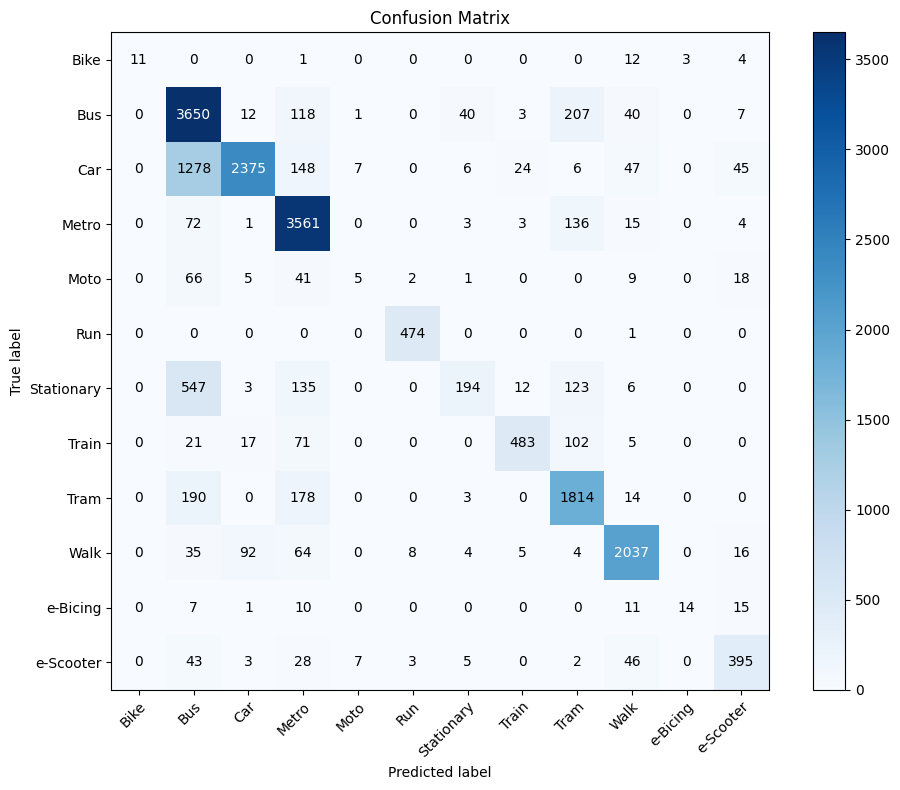

In [12]:
ev.plot_confusion_matrix(fe_dataset.labels[fe_dataset.idx_val], y_pred)

In [13]:
ev.print_report(fe_dataset.labels[fe_dataset.idx_val], y_pred)

              precision    recall  f1-score   support

        Bike       1.00      0.35      0.52        31
         Bus       0.62      0.90      0.73      4078
         Car       0.95      0.60      0.74      3936
       Metro       0.82      0.94      0.87      3795
        Moto       0.25      0.03      0.06       147
         Run       0.97      1.00      0.99       475
  Stationary       0.76      0.19      0.30      1020
       Train       0.91      0.69      0.79       699
        Tram       0.76      0.82      0.79      2199
        Walk       0.91      0.90      0.90      2265
    e-Bicing       0.82      0.24      0.37        58
   e-Scooter       0.78      0.74      0.76       532

    accuracy                           0.78     19235
   macro avg       0.80      0.62      0.65     19235
weighted avg       0.80      0.78      0.77     19235

